# Investigating summary statistics

This notebook tries to evaluate useful summary statistics for an event-related potential (averaged signal of an EEG).
The following evaluations are used:

- post predictive checks
- KL-divergence between $p(\Theta|x)$ and $p(\Theta|x_1)$ (in order to see if KL-divergence increases when certain feature is missing. This would indicate that this feature is important
- ratio of variances of the marginals $p(\Theta|x)$ and $p(\Theta|x_1)$. A high ratio would mean that feature is important (close to 1 would mean that the missing would not change much). 
- histogram plots that compare which feature values prior simulations would cause versus which feature values the posterior simulations cause. We should expect that the posterior histogram distributions are narrower but around the 'true oberservation' (that we unfortunately do not have for real).

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

from utils.plot import cov, compare_vars, plot_varchanges
from utils.plot import compare_KLs, plot_KLs

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

from utils.simulation_wrapper import event_seed, set_network_default, simulation_wrapper,simulation_wrapper_obs, simulation_wrapper_all

sim_wrapper = simulation_wrapper_all


In [40]:
window_len = 30
prior_min = [0, 0, 0, 0, 0, 17.3,  0, 0, 0, 0, 0, 51.980, 0, 0, 0, 0, 112.13]
prior_max = [0.927, 0.160, 2.093, 1.0, 1.0, 35.9, 0.000042, 0.039372, 0.025902,  0.480, 0.117, 75.08, 8.633, 4.104, 1.0, 1.0, 162.110]

prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'


In [41]:

assert (prior.event_shape==torch.Size([17]))
from utils import inference

In [45]:
from utils import inference
from utils.simulation_wrapper import event_seed, simulation_wrapper
import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/'

os.chdir(work_dir)



import os

print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster/')



print(os.getcwd())

os.chdir('/home/ubuntu/results/')

## loading simulations from previously saved computations
#file = 'ERP_sequential_3params/step3'
#file = 'ERP_save_sim_nsf_num_params3'
#file = 'eval_features'
file = '10000_multi_round_num_params_17newparams'

  

thetas = torch.load('{}/thetas.pt'.format(file))

posterior = torch.load('{}/posterior.pt'.format(file))
x_without = torch.load('{}/obs_without.pt'.format(file))

x = calculate_summary_stats_temporal(x_without)


#true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])
#true_params = torch.tensor([[  18.9700, 63.5300, 137.1200]])
#true_params = torch.load('results/{}/true_params.pt'.format(file))
true_params = torch.tensor([[0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 4.6729, 2.33, 0.016733, 0.0679, 120.86]])

print(true_params)

/home/ubuntu/sbi_for_eeg_data
/home/ubuntu/sbi_for_eeg_data
tensor([[2.7700e-01, 3.9900e-02, 6.2440e-01, 3.7390e-01, 0.0000e+00, 1.8977e+01,
         1.2000e-05, 1.1500e-02, 1.3400e-02, 7.6700e-02, 6.3370e-02, 6.3080e+01,
         4.6729e+00, 2.3300e+00, 1.6733e-02, 6.7900e-02, 1.2086e+02]])


## Inference step:

In [9]:
density_estimator = 'nsf'



inf = SNPE(prior=prior, density_estimator = density_estimator)

#inf = SNPE_C(prior, density_estimator="nsf")

inf = inf.append_simulations(thetas, x)

density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)


#true_params = torch.tensor([[26.61, 63.53,  137.12]])

Neural network successfully converged after 57 epochs.


In [46]:
obs_real_stat = posterior.default_x

In [47]:
obs_real_stat

tensor([[ 6.7100e+02,  2.6540e+03,  5.4900e+03,  5.8334e+00, -8.1470e+01,
          1.2142e+02,  3.9604e+00,  2.8273e+01,  1.1775e+02,  2.8438e+00,
          4.9192e+03,  1.0173e+01,  2.5318e+03, -4.7541e+04,  5.0211e+03,
         -5.2468e+04,  2.0490e+05,  0.0000e+00,  3.2625e+01,  2.3954e+00]])

## Simulation under 'true parameters'

In [83]:
true_params = torch.tensor([[0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 4.6729, 2.33, 0.016733, 0.0679, 120.86]])


obs_real = inference.run_only_sim(true_params, simulation_wrapper = sim_wrapper)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
param size 17
early stop 170.0
param size  17
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s finished


In [84]:
obs_real_stat = calculate_summary_stats_temporal(obs_real)

samples = posterior.sample((10000,), x=obs_real_stat)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [22]:


parameter_names = ["prox1_ampa_l2_bas","prox1_ampa_l2_pyr","prox1_ampa_l5_bas","prox1_nmda_l5_bas", "prox1_nmda_l5_pyr",
"t_prox1",
"dist_ampa_l2_pyr","dist_ampa_l2_bas","dist_nmda_l2_pyr",
"dist_nmda_l5_pyr","dist_nmda_l2_bas",
"t_dist", 
"prox2_ampa_l2_pyr","prox2_ampa_l5_pyr","prox2_nmda_l2_pyr","prox2_nmda_l5_pyr",
"t_prox2"]

In [136]:
##better limits:

list_min = list(torch.min(samples, 0)[0]-0.15)
list_max = list(torch.max(samples, 0)[0]+0.15)

limits = [list(tup) for tup in zip(list_min, list_max)]
limits_torch = torch.Tensor(limits)
limits_torch

tensor([[ -0.1500,   0.8250],
        [ -0.1500,   0.3096],
        [ -0.1496,   2.2391],
        [ -0.1474,   1.1190],
        [ -0.1500,   0.1721],
        [ 17.1510,  21.9235],
        [ -0.1500,   0.1500],
        [ -0.1500,   0.1892],
        [ -0.1499,   0.1759],
        [ -0.1327,   0.4759],
        [ -0.1499,   0.2670],
        [ 54.2145,  63.6538],
        [ -0.1325,   8.7022],
        [ -0.1296,   4.2493],
        [ -0.1499,   1.1494],
        [ -0.1499,   0.6734],
        [115.6693, 126.0698]])

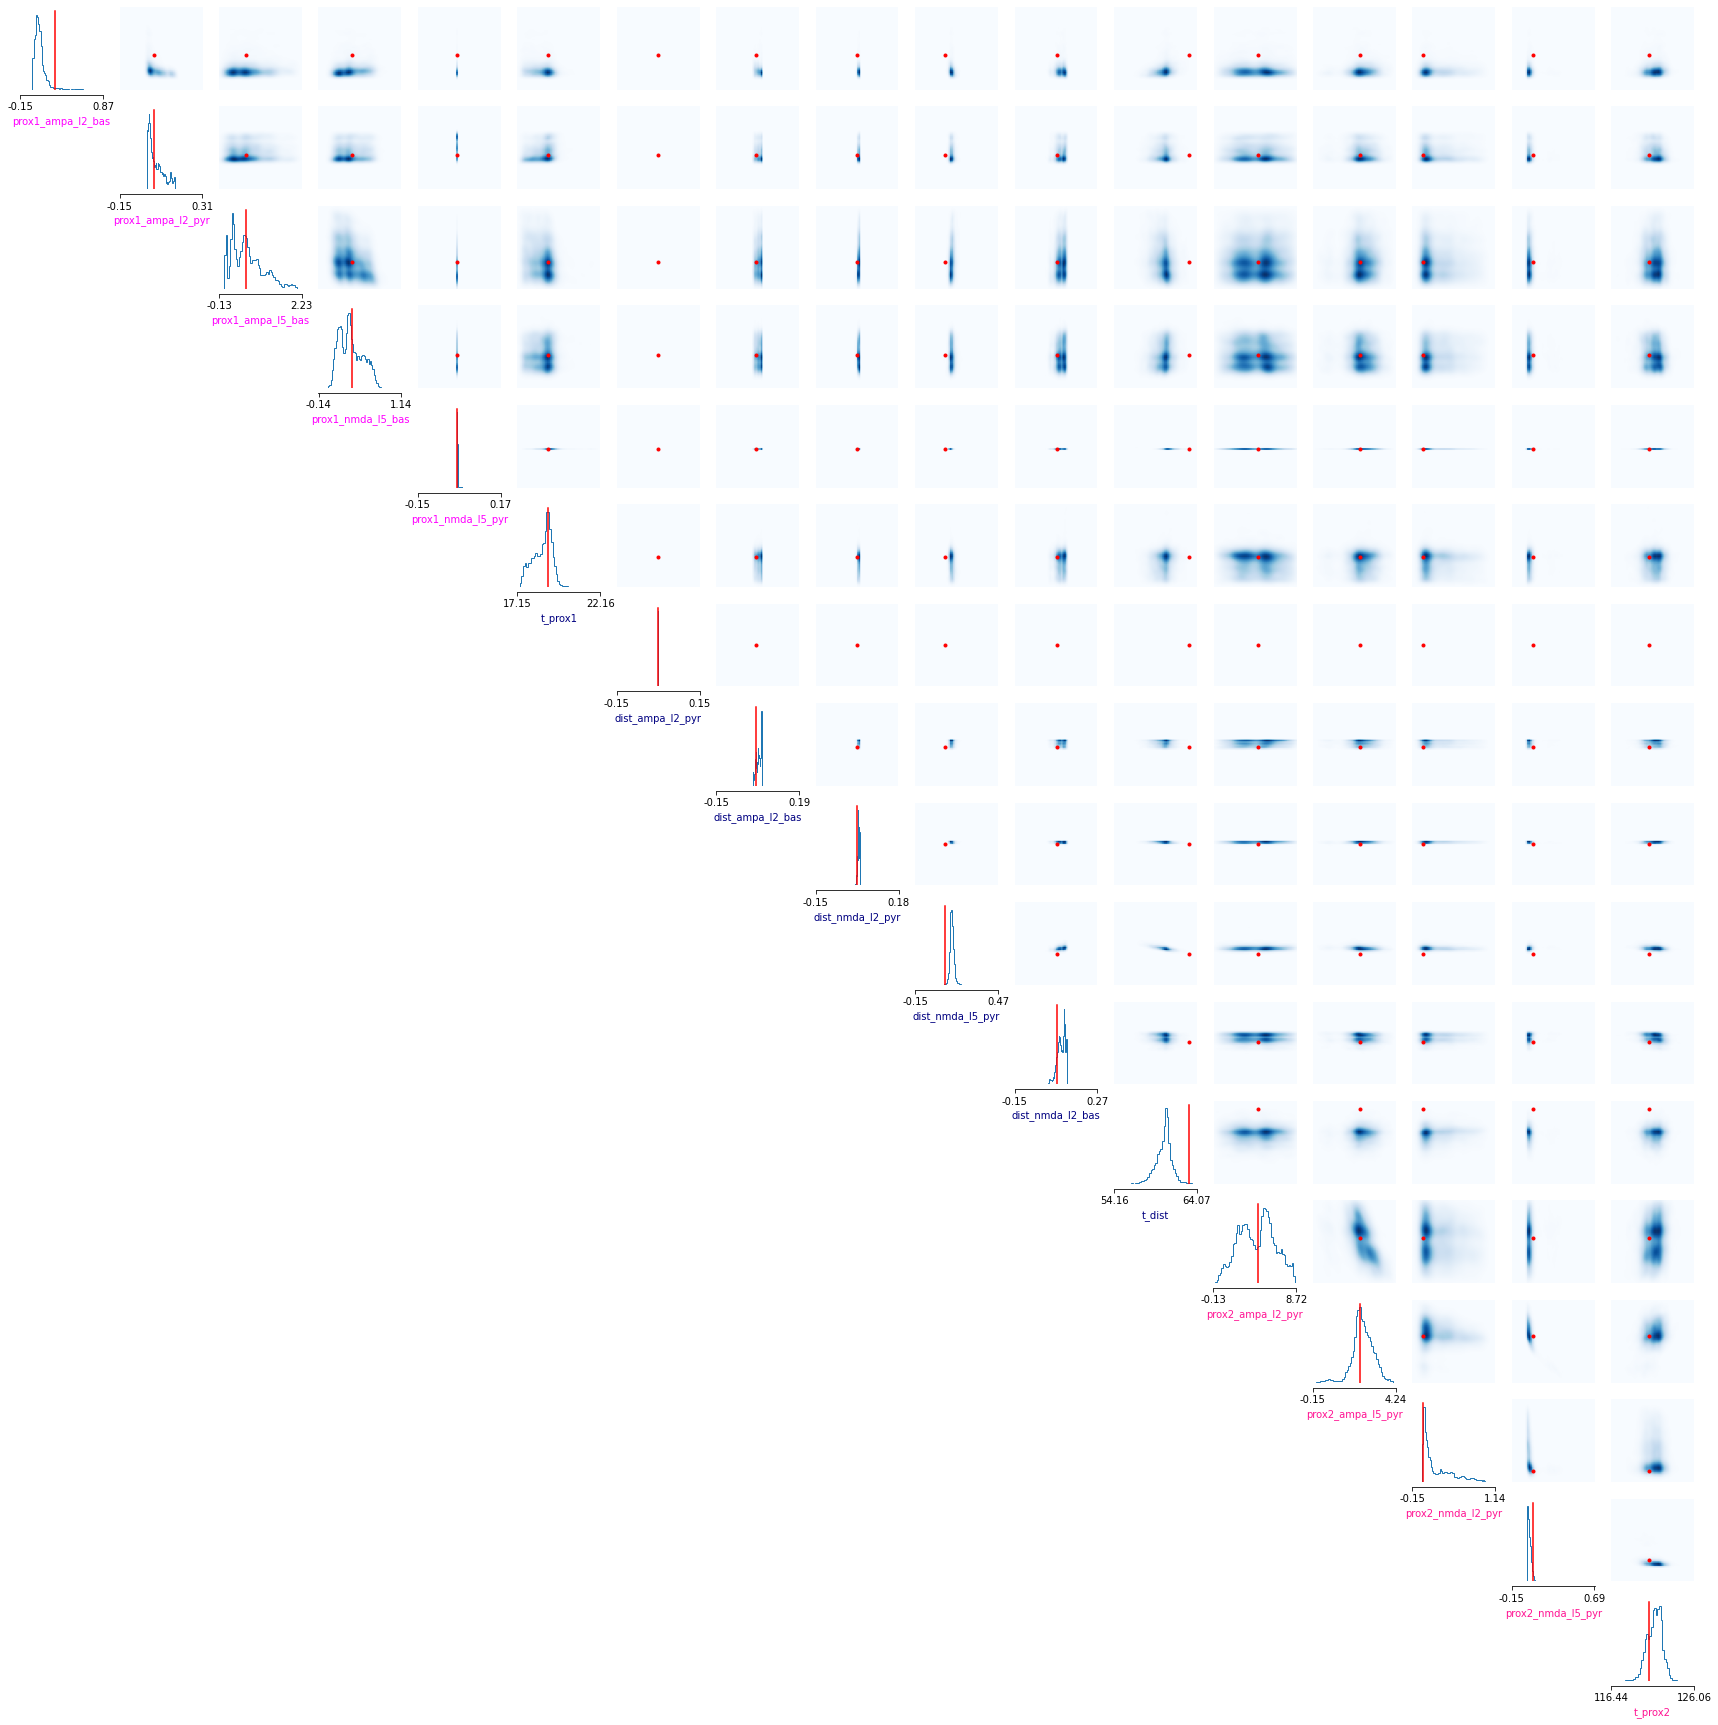

In [27]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    upper = 'kde',
    ticks=np.round(limits,2),
    figsize=(30, 30),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
    kde_offdiag = {
        "alpha": 0.2,
        #"edgecolor": "none",
        #"rasterized": False,
        #'s': mpl.rcParams['lines.markersize'] ** 0.5,
        "bw_method": "scott",
        "bins": 50,
        'cmap': 'viridis'
    }
)

for i in range(5):
    axes[i][i].xaxis.label.set_color('magenta')
for i in range(5, 12):
    axes[i][i].xaxis.label.set_color('navy')
for i in range(12, 17):
    axes[i][i].xaxis.label.set_color('deeppink')

In [101]:
posterior.set_default_x(obs_real_stat)

condition = posterior.sample((1,))

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

In [117]:
true_params = torch.tensor([[0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 4.6729, 2.33, 0.016733, 0.0679, 120.86]])


<Figure size 432x288 with 0 Axes>

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


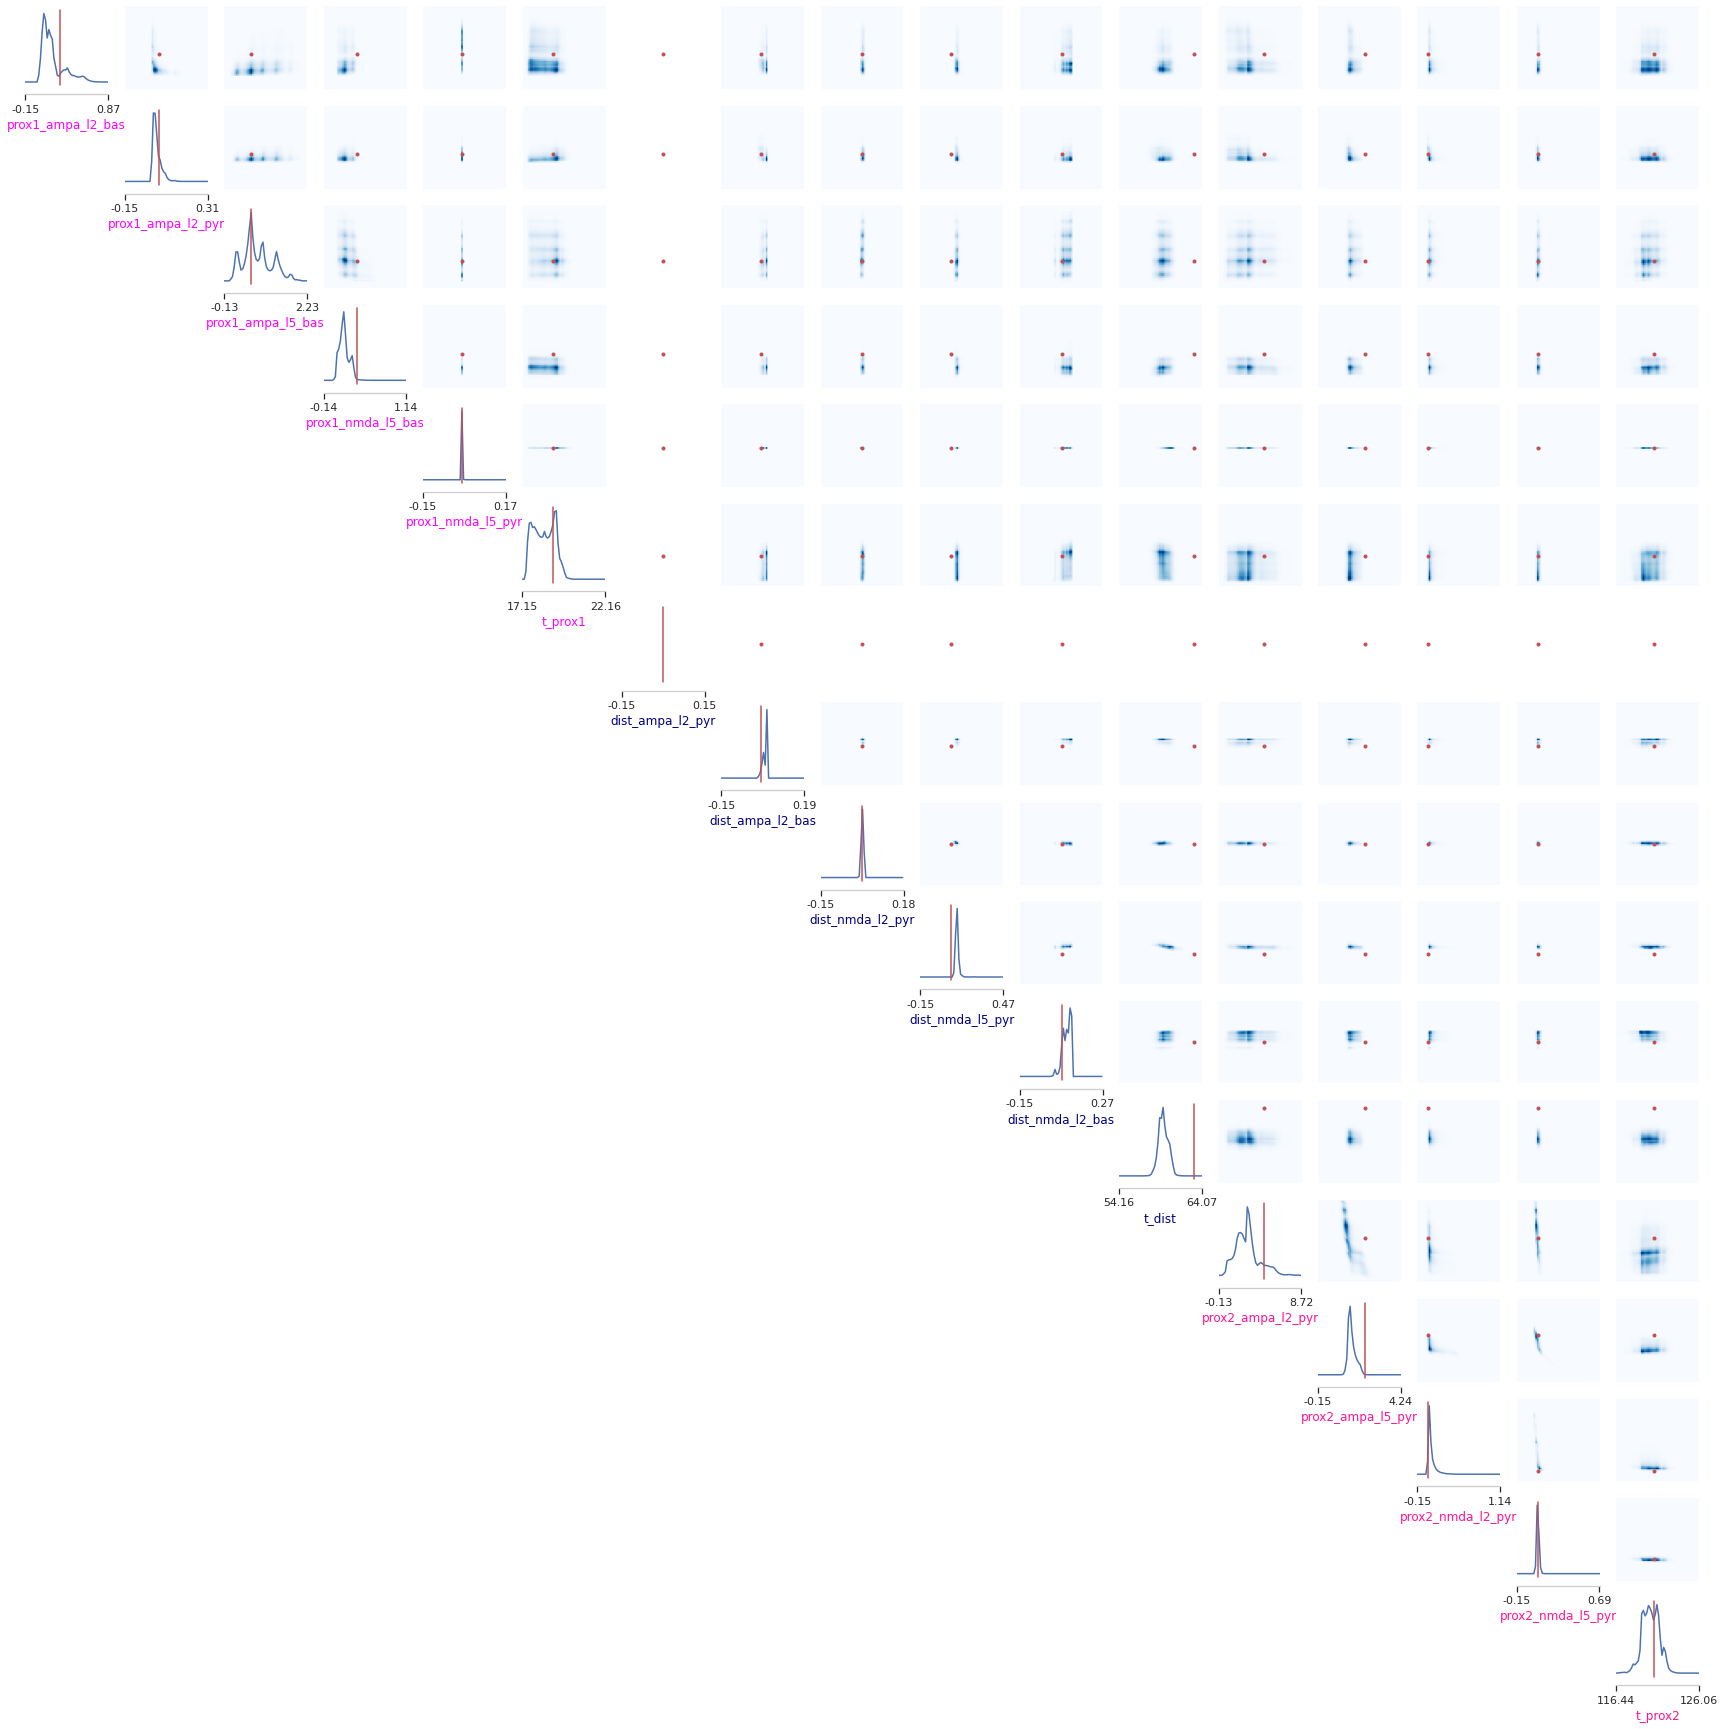

In [119]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]
plt.set_cmap('Blues')

fig, axes = analysis.conditional_pairplot(
    density=posterior,
    condition = condition,
    limits=limits,
    upper = 'hist',
    ticks=np.round(limits,2),
    figsize=(30, 30),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors='r',
    labels=parameter_names,

)

for i in range(6):
    axes[i][i].xaxis.label.set_color('magenta')
for i in range(6, 12):
    axes[i][i].xaxis.label.set_color('navy')
for i in range(12, 17):
    axes[i][i].xaxis.label.set_color('deeppink')

In [ ]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    upper = 'kde',
    ticks=np.round(limits,2),
    figsize=(30, 30),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
    kde_offdiag = {
        "alpha": 0.2,
        #"edgecolor": "none",
        #"rasterized": False,
        #'s': mpl.rcParams['lines.markersize'] ** 0.5,
        "bw_method": "scott",
        "bins": 50,
        'cmap': 'viridis'
    }
)

for i in range(5):
    axes[i][i].xaxis.label.set_color('magenta')
for i in range(5, 12):
    axes[i][i].xaxis.label.set_color('navy')
for i in range(12, 17):
    axes[i][i].xaxis.label.set_color('deeppink')

In [48]:
samples = posterior.sample((100,), x=obs_real_stat)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

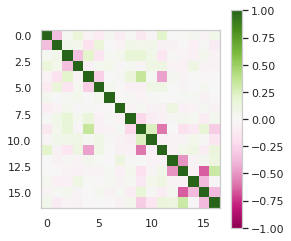

In [120]:
corr_matrix_marginal = np.corrcoef(samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

In [131]:
#limits = torch.stack(limits[0])

limits

tensor([-0.1498,  0.8689])

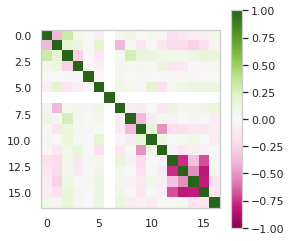

In [137]:
from sbi.analysis import conditional_pairplot, conditional_corrcoeff

cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=limits_torch,
)
fig, ax = plt.subplots(1,1, figsize=(4,4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

In [90]:
#s_x = inference.run_only_sim(samples, simulation_wrapper=sim_wrapper, num_workers=8)

with open('{}/sim_from_samples'.format(file), 'rb') as pickle_file:
    s_x = pickle.load(pickle_file)

In [67]:
samples.shape

torch.Size([100, 17])

In [77]:
samples_prior = torch.stack(samples_prior)

In [78]:
samples_prior.shape

torch.Size([100, 17])

In [ ]:
### sample from prior now
num_samples = 100
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)
    

In [79]:
    
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers=8)

param size 17param size
 early stop17
 170.0
param size  early stop17 
param size170.0
param size   param size1717 

17early stop
param size early stop  17170.0
param size
early stopparam size  17 
early stop17 
170.0
 param sizeparam size 170.0
 17170.0param sizeparam size  
early stop 1717

early stop
 17
param size    170.0
param size  17
17170.0

param size  17
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobs
joblib will run over 1 jobsjoblib will run over 1 jobs

joblib will run over 1 jobsjoblib will run over 1 jobs

[Parallel(n_jobs=8)]: Using backend MultiprocessingBackend with 8 concurrent workers.
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON model
Building the NEURON modelBuilding the NEURON model

Building the NEURON model
[Done]
running trial 1 on 1 cores
[Done]
running trial 1 on 1 cores
[Done]
running trial 1 on 1 cores
Simulation t

Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time: 100.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 90.0 ms...
Simulation time: 120.0 ms...
Simulation time: 110.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Simulati

 17
joblib will run over 1 jobs
param size 17
early stop 170.0
[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed:  4.9min
param size  17
joblib will run over 1 jobsBuilding the NEURON model

Building the NEURON model
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 20.0 ms...
param size 17
early stop 170.0
param size  [Parallel(n_jobs=8)]: Done  22 tasks      | elapsed:  4.9min
17
joblib will run over 1 jobs
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 30.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
param size 17
early stop 170.0
[Parallel(n_jobs=8)]: Done  23 tasks      | elapsed:  5.0min
param size  17
joblib will run over 1 jobs
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Building the NEURON model
param size 

Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 110.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 100.0 ms...
Simulation time: 50.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 100.0 ms...
Simulation time: 90.0 ms...
Simulation time: 110.0 ms...
Simulation time: 60.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 130.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 120.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 140.0 ms...
Simulation time: 120.0 ms...
Simulation time: 110.0 ms...
Simulation time: 130.0 ms...
Simulation time: 100.0 ms...
Simulation time: 80.0 ms...
Simulation time: 110.0 ms...
Simulation time: 110.0 ms...
Si

joblib will run over 1 jobs
Simulation time: 140.0 ms...
param size 17
early stop Building the NEURON model170.0

param size [Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 10.1min
 17
joblib will run over 1 jobs
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
param size 17
early stop 170.0
param size [Parallel(n_jobs=8)]: Done  46 tasks      | elapsed: 10.2min
 17
Simulation time: 20.0 ms...
joblib will run over 1 jobs
Building the NEURON model
Simulation time: 10.0 ms...
param size 17
early stop 170.0
param size  17[Parallel(n_jobs=8)]: Done  47 tasks      | elapsed: 10.2min

joblib will run over 1 jobs
Building the NEURON model
Building the NEURON model
Simulation time: 150.0 ms...
Simulation time: 10.0 ms...
Simulation time: 30.0 ms...
Simulation time: 20.0 ms...
Simulation time: 20.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 30.0 

Simulation time: 40.0 ms...
Simulation time: 100.0 ms...
Simulation time: 70.0 ms...
Simulation time: 110.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 110.0 ms...
Simulation time: 90.0 ms...
Simulation time: 50.0 ms...
Simulation time: 110.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 80.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 100.0 ms...
Simulation time: 90.0 ms...
Simulation time: 120.0 ms...
Simulation time: 60.0 ms...
Simulation time: 130.0 ms...
Simulation time: 90.0 ms...
Simulation time: 130.0 ms...
Simulation time: 90.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 130.0 ms...
Simulation time: 70.0 ms...
Simulation time: 140.0 ms...
Simulation time: 100.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...

Simulation time: 0.03 ms...
Simulation time: 20.0 ms...
param size 17
early stop 170.0
param size  17
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 15.3min
param size 17
early stop 170.0
param size  17
Simulation time: 160.0 ms...
Simulation time: 20.0 ms...joblib will run over 1 jobs

[Parallel(n_jobs=8)]: Done  70 tasks      | elapsed: 15.3min
Building the NEURON model
Building the NEURON model
Simulation time: 10.0 ms...
Simulation time: 140.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
param size 17
early stop 170.0
param size  17
[Done]
running trial 1 on 1 cores
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  71 tasks      | elapsed: 15.4min
Simulation time: 0.03 ms...
Simulation time: 20.0 ms...
Building the NEURON model
Simulation time: 150.0 ms...
Simulation time: 40.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 40.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.0

Simulation time: 80.0 ms...
Simulation time: 110.0 ms...
Simulation time: 80.0 ms...Simulation time: 80.0 ms...

Simulation time: 120.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 110.0 ms...
Simulation time: 90.0 ms...
Simulation time: 120.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 130.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 100.0 ms...
Simulation time: 130.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 140.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 130.0 ms...
Simulation time: 110.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...Simulation time: 110.0 ms...

Simulation time: 110.0 ms...
Simulation time: 70.0 ms...
Simulation time: 100.0 ms...Simulation time: 140.0 ms...

Simulation time: 120.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms..

Simulation time: 0.03 ms...
Simulation time: 30.0 ms...
[Parallel(n_jobs=8)]: Done  95 out of 100 | elapsed: 20.7min remaining:  1.1min
Simulation time: 140.0 ms...
Simulation time: 10.0 ms...
Simulation time: 40.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 40.0 ms...
Simulation time: 20.0 ms...
Simulation time: 150.0 ms...
Simulation time: 10.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 30.0 ms...
Simulation time: 20.0 ms...
Simulation time: 160.0 ms...
Simulation time: 60.0 ms...
Simulation time: 30.0 ms...
Simulation time: 60.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time

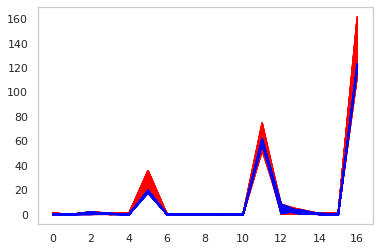

In [80]:
for sample in samples_prior:
    plt.plot(sample, c='red')
    
for sample in samples:
    plt.plot(sample, c='blue')

In [91]:
s_x_torch = torch.stack(([s_x[i] for i in range(len(s_x))]))
s_x_prior_torch = torch.stack(([s_x_prior[i] for i in range(len(s_x_prior))]))


mean = torch.mean(s_x_torch, 0)
std = torch.std(s_x_torch, 0)

mean_prior = torch.mean(s_x_prior_torch, 0)
std_prior = torch.std(s_x_prior_torch, 0)

lower = mean - 1.96 * std


upper = mean + 1.96 * std


lower_prior = mean_prior - 1.96 * std_prior


upper_prior = mean_prior + 1.96 * std_prior



In [95]:

s_x = torch.stack(s_x)

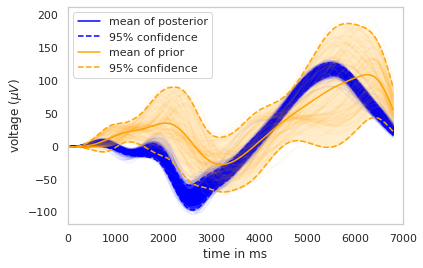

In [96]:
import seaborn as sns

sns.set() 

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style('ticks')

fig1, ax = plt.subplots(1, 1)
#ax.set_title("Comparing signal")

    
plt.plot(mean, color ='blue', label='mean of posterior')

for s in s_x:
    plt.plot(s, alpha=0.05, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)

plt.plot(lower, color='blue', linestyle='dashed', label='95% confidence')
plt.plot(upper, color='blue', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower, y2=upper, color='blue', alpha=0.01)
plt.xlim(0, 7000)


plt.plot(mean_prior, color ='orange', label='mean of prior')


for x_w in s_x_prior:
    plt.plot(x_w, alpha=0.05, color='orange')

plt.plot(lower_prior, color='orange', linestyle='dashed', label='95% confidence')
plt.plot(upper_prior, color='orange', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower_prior, y2=upper_prior, color='orange', alpha=0.2)
plt.xlim(0, 7000)

plt.xlabel('time in ms')
#plt.ylabel('voltage ()')

fig1.gca().set_ylabel(r'voltage ($\mu V$)')
    
#plt.plot(obs_real[0], label='Ground truth', color='red')



plt.legend()

In [100]:
prior_max = [0.927, 0.160, 2.093, 1.0, 1.0, 35.9, 0.000042, 0.039372, 0.025902,  0.480, 0.117, 75.08, 8.633, 4.104, 1.0, 1.0, 162.110]

#true_params = torch.tensor([[26.61, 63.53,  137.12]])
true_params = [0.277, 0.0399, 0.6244, 0.3739, 0.0, 18.977, 0.000012, 0.0115, 0.0134,  0.0767, 0.06337, 63.08, 4.6729, 2.33, 0.016733, 0.0679, 120.86]


assert prior_max > true_params

## Evaluation of features

In [28]:
import matplotlib.cm as cm
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch import Tensor
from typing import Tuple, List, Optional, Dict
from matplotlib.pyplot import Axes
from matplotlib.figure import Figure
from matplotlib.colors import LogNorm


In [68]:
t = obs_real_stat

t

tensor([[ 1.9490e+03,  2.7060e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,
          1.9919e+02,  1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,
          7.0213e+03,  1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04,
         -2.2304e+04,  3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00]],
       dtype=torch.float64)

In [74]:
# t.shape

t1 = torch.cat((t[:,:1], t[:,1+1:]), axis = 1)
print(t1)
t1.shape

tensor([[ 1.9490e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,  1.9919e+02,
          1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,  7.0213e+03,
          1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04, -2.2304e+04,
          3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00]],
       dtype=torch.float64)


torch.Size([1, 19])

In [54]:
posterior.set_default_x(obs_real_stat)

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=BoxUniform(Uniform(low: torch.Size([17]), high: torch.Size([17])), 1),
               x_shape=torch.Size([1, 20]))
               

In [55]:
thetas = posterior.sample((10000,))
thetas.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 17])

In [79]:

for i in range(20):
    x = calculate_summary_stats_temporal(x_without)
    #leaving one summary statistic out
    x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
    print(x_c.shape)
    print('t shape', t.shape)
    print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
    inf = SNPE(prior=prior, density_estimator = 'nsf')
    inf = inf.append_simulations(thetas, x_c)
    density_estimator = inf.train()
    posterior1 = inf.build_posterior(density_estimator)
    globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))


torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

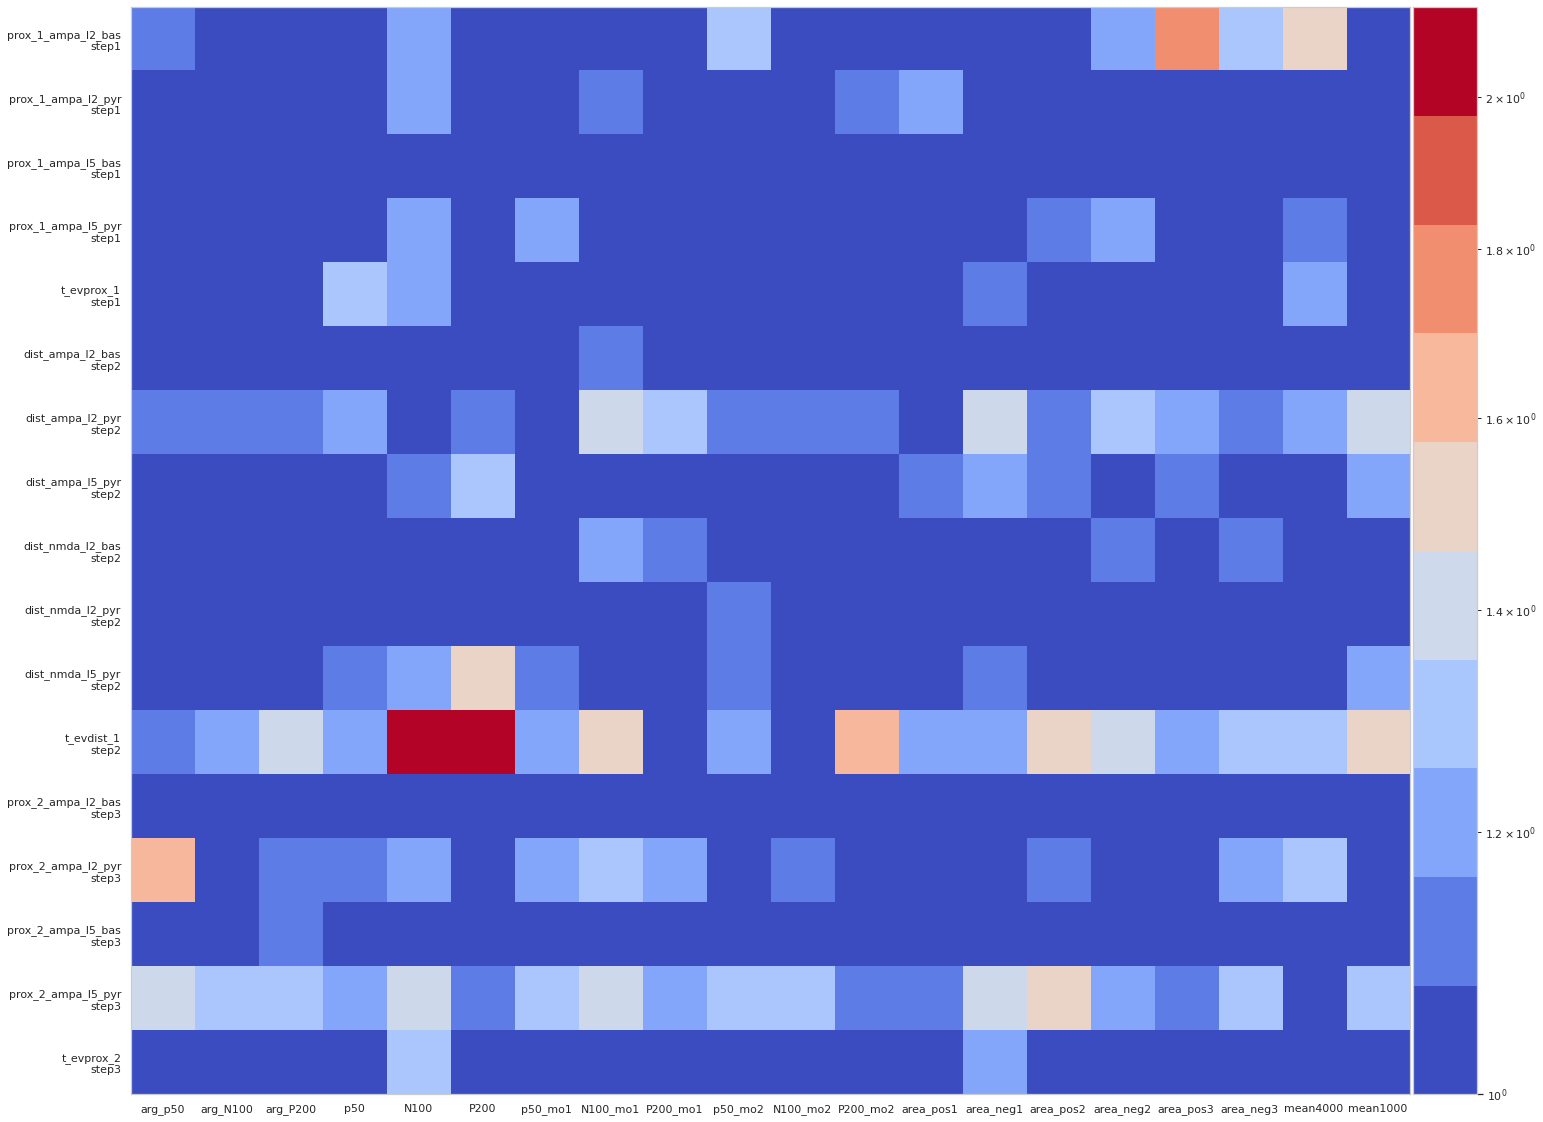

In [106]:
sum_stats_names =                 [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_mo1',
                    'N100_mo1',
                    'P200_mo1',
                    'p50_mo2',
                    'N100_mo2',
                    'P200_mo2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

sample_list = []
for i in range(20):
    sample_list.append(globals()['samples_%s' % i] )

    
plt.figure(figsize = (25,20))
im = plot_varchanges(sample_list, samples, xticklabels=sum_stats_names, yticklabels= parameter_names, plot_label='', batchsize=0)
plt.show(im)

In [120]:
sample_batch = []
batch_size = 5

for i in range(batch_size):

    sample_list = []
    
    for i in range(20):
        

        x = calculate_summary_stats_temporal(x_without)
        #leaving one summary statistic out
        x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
        print(x_c.shape)
        print('t shape', t.shape)
        print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
        inf = SNPE(prior=prior, density_estimator = 'nsf')
        inf = inf.append_simulations(thetas, x_c)
        density_estimator = inf.train()
        posterior1 = inf.build_posterior(density_estimator)
        globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))
        
        sample_list.append(globals()['samples_%s' % i] )
        
    sample_batch.append(sample_list)

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 36 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 36 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])


KeyboardInterrupt: 

In [119]:
sample_batch

[]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0, 0.5, 'voltage ($\\mu V$)')

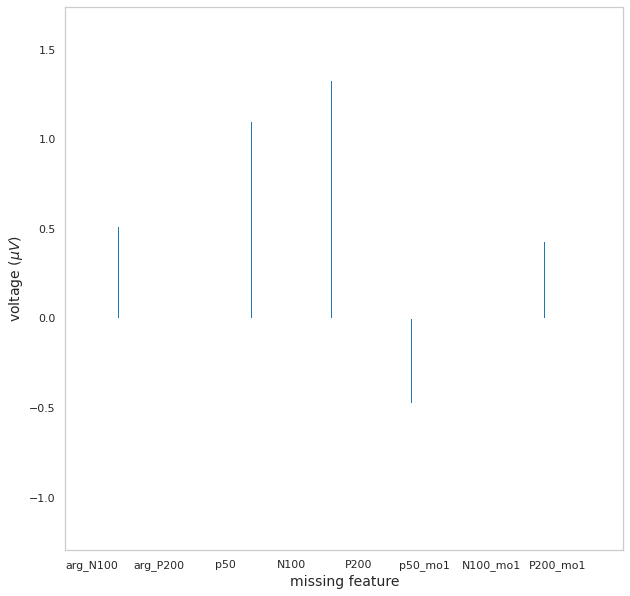

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True)


plot_KLs(sample_list,
        samples,
        idx=0,
        batchsize=0,
         kind='bar',
        agg_with='mean'
    )


axes.set_xlabel("missing feature", size=14)
axes.set_xticklabels(sum_stats_names)
ax.tick_params(axis="both", which="major", labelsize=12)
ylabel = ax.get_ylabel()
axes.set_ylabel(ylabel, size=14)


In [121]:
s_x_prior_stat = calculate_summary_stats_temporal(s_x_prior)
s_x_stat = calculate_summary_stats_temporal(s_x)
                                                

In [134]:
t[0]

tensor([ 1.9490e+03,  2.7060e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,
         1.9919e+02,  1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,
         7.0213e+03,  1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04,
        -2.2304e+04,  3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00],
       dtype=torch.float64)

34.410999999999994
8.821
9.030999999999999
0.3426654206472814
1.1908244735227738
0.7454976427279791
0.2929940479865423
0.4804624729637844
0.7634706273832214
1.0836820944991712
73.10182756863495
0.595378369776133
426.12008548256523
408.09902244746615
340.98481557103173
727.042788425355
1380.5021171318183
0.001
0.5525858938078323
0.16738297339680588


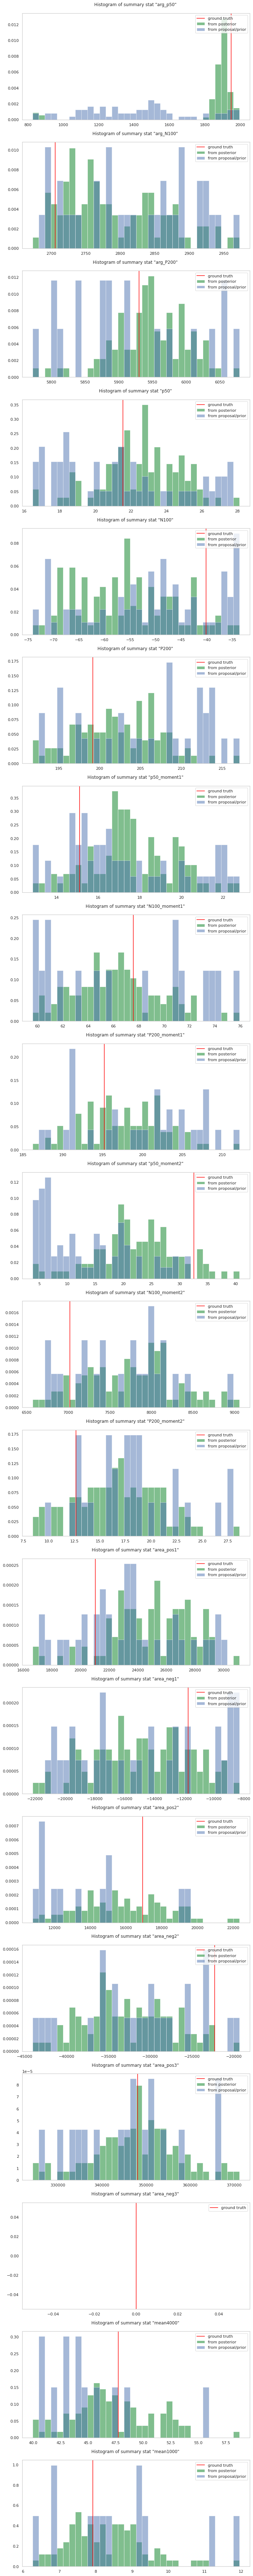

In [137]:
import matplotlib.gridspec as gridspec

sum_stats_names =                  [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_moment1',
                    'N100_moment1',
                    'P200_moment1',
                    'p50_moment2',
                    'N100_moment2',
                    'P200_moment2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

fig = plt.figure(figsize=(10,5*len(s_x_stat[0])), tight_layout=True)

gs = gridspec.GridSpec(nrows=len(sum_stats_names), ncols=1)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(len(s_x)):
        globals()['sum_stats%s' % i].append(float(s_x_stat[j][i]))
        globals()['x%s' % i].append(float(s_x_prior_stat[j][i]))

    sum_stat = globals()['sum_stats%s' % i]
    
    
    ##define bins such that we get an equal number of bins at the end
    
    binsteps = np.abs(max(sum_stat)-min(sum_stat))*0.03 + 0.001
    
    print(binsteps)
   
    binrange = np.arange(min(sum_stat), max(sum_stat) + binsteps, binsteps)
    
   
    
    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, bins = binrange,  facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, bins = binrange,   facecolor='b', alpha=0.5, histtype='barstacked', label='from proposal/prior')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(t[0][i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')